In [49]:
import os
import numpy as np
import random
import torch
import time
import optuna
from DQN.train_dqn import train_dqn
from pathlib import Path
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [50]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [51]:
from envs.GraphEnv.impnode import ImpnodeEnv
from DQN import DQN_agent_modular

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

RESULTS_BASEPATH_TEST1 = 'results\hyp_search_2\cuda_0.001_4000_1000_0.99_128_1500_300_1.0_0.05_300_0.001_4_2_32_64_1_3_(30, 50)_dw_nd_barabasi_albert_20240407152655'

In [53]:
# variables for training the agent
def objective(trial):
    num_train_eps = trial.suggest_int('num_train_eps', 100, 2000, 500)
    num_mem_fill_eps = trial.suggest_int('num_mem_fill_eps', 100, 2000, 500)
    discount = 0.99 
    batch_size = 32 
    mem_capacity = 500  
    update_frequency = 10
    eps_max = 0.1 
    eps_min = 0.05 
    eps_step = 10
    lr = 0.0002
    alpha = 0.001
    
    gnn_depth=4
    state_size=2
    hidden_size1=32
    hidden_size2=64
    action_size=1
    n_step=3
    
    num_nodes = (30, 50)
    anc = 'dw_nd'   
    
    dqn_agent_train = DQN_agent_modular.DQNAgent(device,
                                             alpha=alpha,
                                             gnn_depth=gnn_depth,
                                             state_size=state_size,
                                             hidden_size1=hidden_size1,
                                             hidden_size2=hidden_size2,
                                             action_size=action_size,
                                             discount=discount,
                                             eps_max=eps_max,
                                             eps_min=eps_min,
                                             eps_step=eps_step,
                                             memory_capacity=mem_capacity,
                                             lr=lr,
                                             mode='finetune',
                                             unfrozen_layers=['linear1','linear2','linear3','linear4', 'linear5', 'dense1', 'dense2'])
    dqn_agent_train.load_model('{}/model.pt'.format(RESULTS_BASEPATH_TEST1))
    
    subdir = 'data/cm/Crime_degree'
    data_path = Path.cwd() / subdir
    model_name = 'crime_finetuned_model'
    env_train = ImpnodeEnv(anc=anc, 
                           g_type='barabasi_albert', 
                           num_nodes=num_nodes, 
                           mode='finetune',
                           data_path=data_path
                           )
    
    val_data_path = 'data/cm/Crime_degree_val'
    val_data_path = Path.cwd()/val_data_path
    
    results_base_path_train = "results/hyp_search_finetune/{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                           device, alpha, num_train_eps, num_mem_fill_eps, discount, batch_size, mem_capacity, update_frequency, eps_max, eps_min, eps_step, lr, gnn_depth, state_size, hidden_size1, hidden_size2, action_size, n_step, num_nodes, anc)

    if not os.path.exists(results_base_path_train):
        os.makedirs(results_base_path_train)
    else:
        timestamp = time.strftime("%Y%m%d%H%M%S")
        new_directory = f"{results_base_path_train}_{timestamp}"
        os.makedirs(new_directory)
        results_base_path_train = new_directory
        print(f"Directory already exists. Created a new one: {new_directory}")

    avg_train = train_dqn(env_train, dqn_agent_train, results_base_path_train, num_train_eps, num_mem_fill_eps, n_step, batch_size, update_frequency, val_data_path, model_name, mode='finetune')
    return avg_train


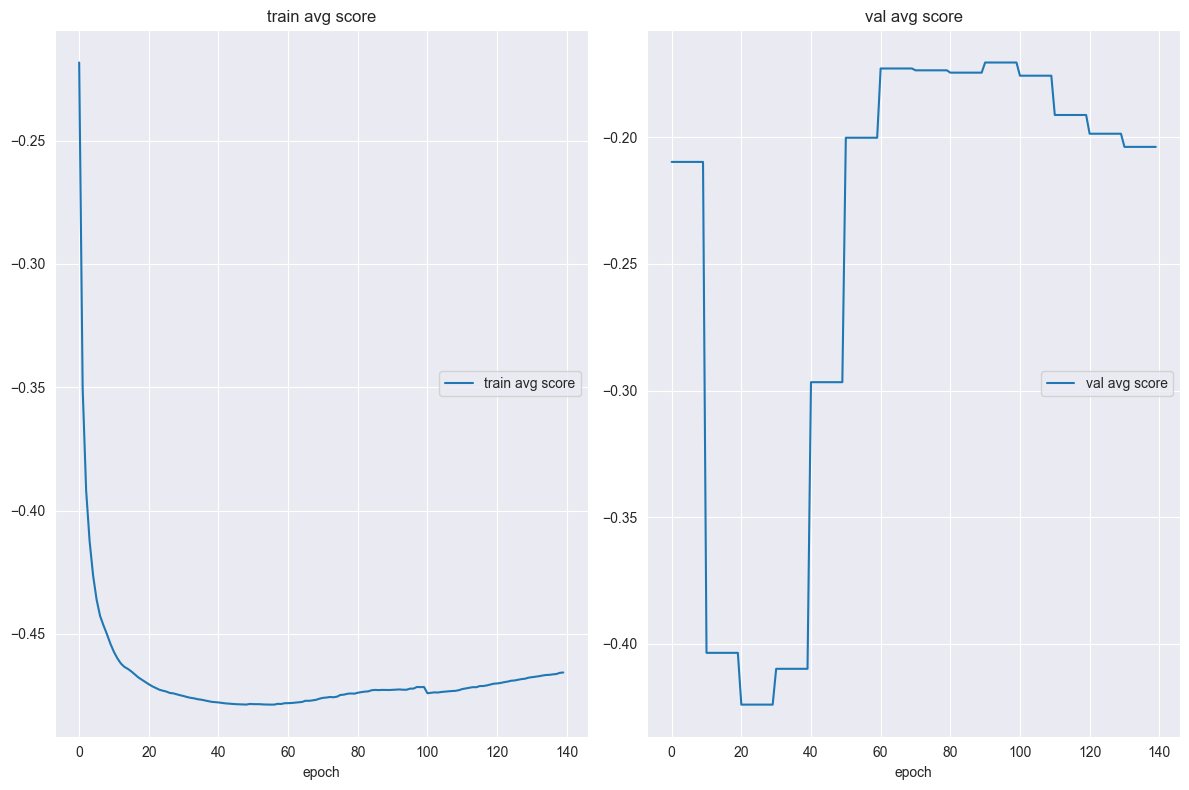

train avg score
	train avg score  	 (min:   -0.479, max:   -0.218, cur:   -0.466)
val avg score
	val avg score    	 (min:   -0.424, max:   -0.170, cur:   -0.204)


[I 2024-04-10 14:15:43,343] Trial 14 finished with value: -0.4655638643177619 and parameters: {'num_train_eps': 600, 'num_mem_fill_eps': 1100}. Best is trial 14 with value: -0.4655638643177619.


EarlyStopping counter: 5 out of 5
Early stopping
linear1 is unfrozen
linear2 is unfrozen
linear3 is unfrozen
linear4 is unfrozen
sum_agg is frozen
linear5 is unfrozen
dense1 is unfrozen
dense2 is unfrozen
Directory already exists. Created a new one: results/hyp_search_finetune/cuda_0.001_600_600_0.99_32_500_10_0.1_0.05_10_0.0002_4_2_32_64_1_3_(30, 50)_dw_nd_20240410141543


[W 2024-04-10 14:16:09,796] Trial 15 failed with parameters: {'num_train_eps': 600, 'num_mem_fill_eps': 600} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\rituja.pardhi\.conda\envs\impnode-gpu\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\rituja.pardhi\AppData\Local\Temp\1\ipykernel_2624\3853382150.py", line 67, in objective
    avg_train = train_dqn(env_train, dqn_agent_train, results_base_path_train, num_train_eps, num_mem_fill_eps, n_step, batch_size, update_frequency, val_data_path, model_name, mode='finetune')
  File "C:\rituja_git\ma-rituja-pardhi\DQN\train_dqn.py", line 41, in train_dqn
    action = agent.select_action(state, mask)
  File "C:\rituja_git\ma-rituja-pardhi\DQN\DQN_agent_modular.py", line 130, in select_action
    action = self.policy_net.forward(batch_of_state).squeeze(1)
  File "C:\rituja_git\ma-rituja-pardhi\DQN\model.py", line 67,

KeyboardInterrupt: 

In [54]:
study = optuna.create_study(direction='maximize', storage="sqlite:///db.finetune")
study.optimize(objective, n_trials=100)

In [ ]:
study.best_params

In [ ]:
import matplotlib.pyplot as plt
import plotly

In [ ]:
optuna.visualization.plot_optimization_history(study)


In [57]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
files = [str(f)+'\info_finetune.csv' for f in pathlib.Path('{}/results/hyp_search_finetune'.format(pathlib.Path.cwd())).iterdir() if f.is_dir()]

In [58]:
dataframes = []
for file in files:
    df = pd.read_csv(file) 
    
    df['source'] = file.split('\\')[-2]
    dataframes.append(df)

In [59]:
df_all = pd.concat(dataframes)
df_all

,ep_cnt,train_avg_score,val_avg_score,source
0,1600,-0.231476,-0.191172,cuda_0.001_100_1600_0.99_32_500_10_0.1_0.05_10...
1,1601,-0.352960,-0.191172,cuda_0.001_100_1600_0.99_32_500_10_0.1_0.05_10...
2,1602,-0.394587,-0.191172,cuda_0.001_100_1600_0.99_32_500_10_0.1_0.05_10...
3,1603,-0.411208,-0.191172,cuda_0.001_100_1600_0.99_32_500_10_0.1_0.05_10...
4,1604,-0.425385,-0.191172,cuda_0.001_100_1600_0.99_32_500_10_0.1_0.05_10...
...,...,...,...,...
45,645,-0.475729,-0.285760,cuda_0.001_600_600_0.99_32_500_10_0.1_0.05_10_...
46,646,-0.475956,-0.285760,cuda_0.001_600_600_0.99_32_500_10_0.1_0.05_10_...
47,647,-0.476174,-0.285760,cuda_0.001_600_600_0.99_32_500_10_0.1_0.05_10_...
48,648,-0.476188,-0.285760,cuda_0.001_600_600_0.99_32_500_10_0.1_0.05_10_...


C:\Users\rituja.pardhi\AppData\Local\Temp\1\ipykernel_2624\2422581983.py:2: UserWarning: The palette list has more values (99) than needed (15), which may not be intended.
  ax = sns.lineplot(df_all, y='val_avg_score', x='ep_cnt', hue='source', palette=sns.color_palette("tab20", 99))


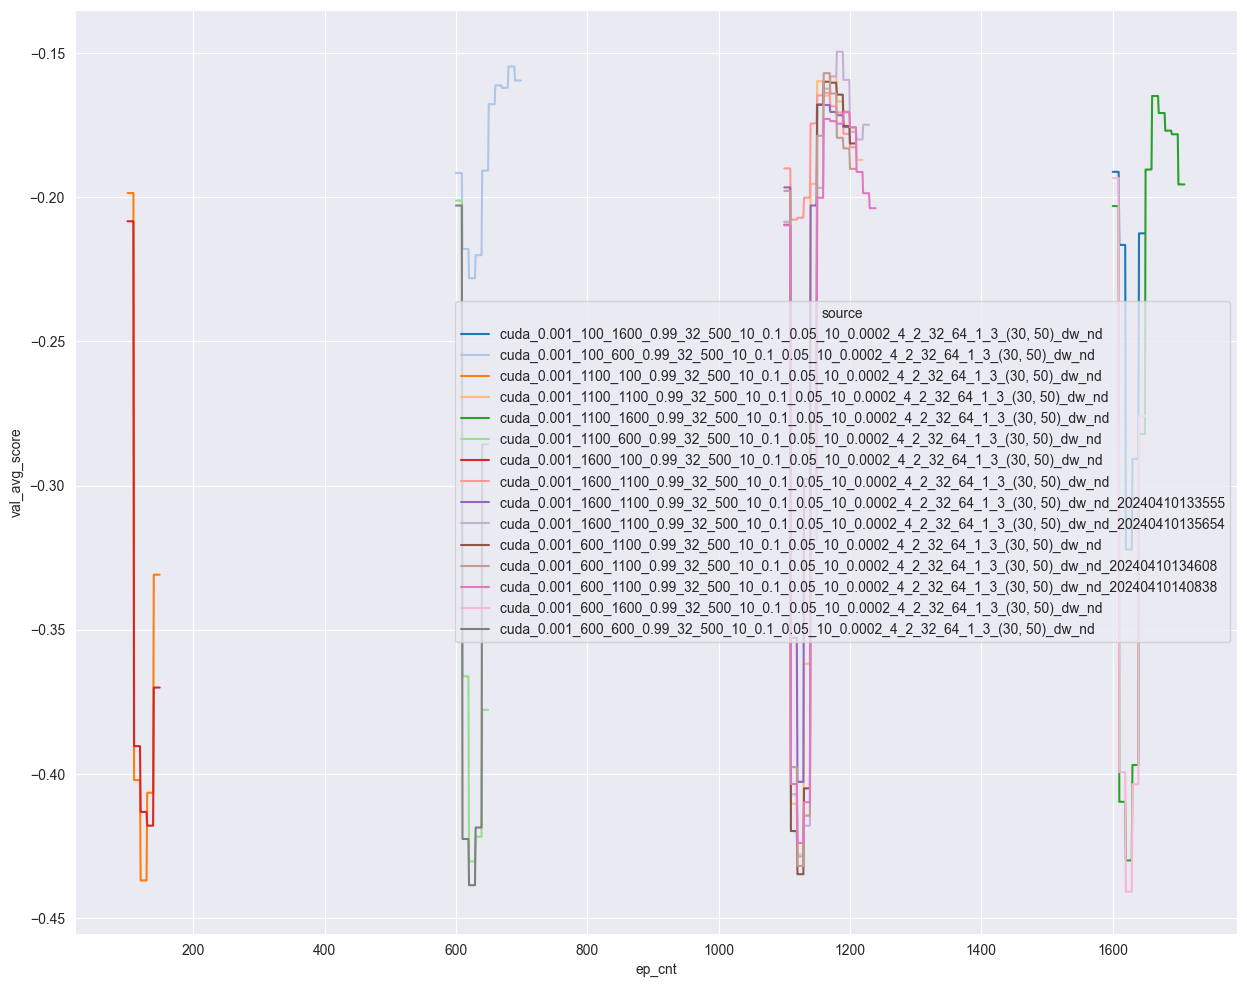

In [63]:
plt.figure(figsize=(15,12))
ax = sns.lineplot(df_all, y='val_avg_score', x='ep_cnt', hue='source', palette=sns.color_palette("tab20", 99))
sns.move_legend(ax, "right")